In [1]:
import pandas as pd
import os
import re
import sys
import sklearn
import glob
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.lines as mlines
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load all CSV file paths
all_files = glob.glob(os.path.join("../monthly_data", "*.csv"))

# Read each file and store in a list
df_list = [pd.read_csv(f) for f in all_files]

# Combine all DataFrames into a single one
bms_df = pd.concat(df_list, ignore_index=True)

In [5]:
bms_df.columns

Index(['Unnamed: 0', 'date', 'FCU-01 Watt', 'FCU-1 Cooling Load_kW',
       'FCU-01 KWh', 'FCU-03 Watt', 'FCU-3 Cooling Load_kW',
       'FCU-03 Return Temp', 'FCU-03 Return Air Humi',
       'FCU-03 Return Air CO2 Level',
       ...
       'FCU-03 CHW Flow Rate', 'FCU-03 Temp Set Point_x',
       'FCU-03 Temp Set Point_y', 'PFCU-01 CHW Flow Rate',
       'FCU-04 CHW Flow Rate', 'PFCU-02 CHW Flow Rate', 'Main Incomming Watt',
       'Main Incomming KWh', 'FCU-05 CHW Flow Rate', 'FCU-02 CHW Flow Rate_y'],
      dtype='object', length=173)

# 4.1 Data Cleaning (Null Value analysis)

### (1) Row-wise analysis (Timestamps)

In [6]:
# 1) Unify Column name as 'Timestamp' (date -> timestamp)
if "date" in bms_df.columns:   
    bms_df.rename(columns={"date": "Timestamp"}, inplace=True)
    
# 2) Delete 'Unnamed' column 
bms_df.drop(columns=[col for col in bms_df.columns if "Unnamed" in col], inplace=True, errors="ignore")

In [ ]:
# type change (str -> datetime)
bms_df["Timestamp"] = (
    pd.to_datetime(bms_df["Timestamp"], errors="coerce")  # string → datetime 
    .dropna()                                             # eliminate NaT
)
bms_df = bms_df.sort_values("Timestamp").reset_index(drop=True)     # Sort based on "Timestamp" column and reset index

Visualize Timestamp Gap

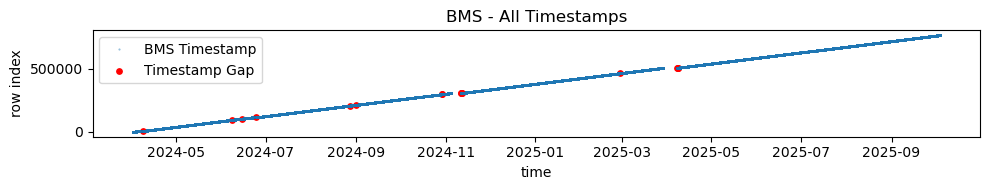

In [8]:
plt.figure(figsize=(10,2))

# Convert timestamps
bms_ts = pd.to_datetime(bms_df["Timestamp"], errors="coerce").dropna()

# Plot all timestamps
plt.plot(bms_ts, range(len(bms_ts)), marker=".", linestyle="", alpha=0.5, markersize=1, label="BMS Timestamp")

# Find discontinuities (> 1 min gap)
diffs = bms_ts.diff()
gaps = diffs[diffs > pd.Timedelta(minutes=1)]

# Mark those discontinuities with orange dots
plt.scatter(bms_ts.loc[gaps.index], gaps.index, color="red", s=15, label=f"Timestamp Gap")

plt.title("BMS - All Timestamps")
plt.xlabel("time")
plt.ylabel("row index")
plt.legend()
plt.tight_layout()
plt.show()

View Timestamp Gap

In [9]:
def find_timestamp_gaps(df, freq="1min"):
    # 1) Ensure Timestamp is datetime
    ts = pd.to_datetime(df["Timestamp"], errors="coerce").dropna().sort_values()

    # 2) Calculate difference between consecutive rows
    diffs = ts.diff()

    # 3) Find where gap is larger than expected frequency
    expected = pd.to_timedelta(freq)
    gaps = diffs[diffs > expected]

    # 4) Report results
    if gaps.empty:
        print("✅ No gaps found in timestamps.")
    else:
        print("⚠️ Gaps detected:")
        for idx, gap in gaps.items():
            print(f" - Gap of {gap} after {ts.loc[idx - 1]} → resumes at {ts.loc[idx]}")

In [24]:
find_timestamp_gaps(bms_df, freq="1min")

⚠️ Gaps detected:
 - Gap of 0 days 00:03:00 after 2024-02-02 05:00:00 → resumes at 2024-02-02 05:03:00
 - Gap of 0 days 00:07:00 after 2024-02-02 07:12:00 → resumes at 2024-02-02 07:19:00
 - Gap of 0 days 00:04:00 after 2024-02-02 07:20:00 → resumes at 2024-02-02 07:24:00
 - Gap of 0 days 00:02:00 after 2024-02-02 07:28:00 → resumes at 2024-02-02 07:30:00
 - Gap of 0 days 00:02:00 after 2024-02-02 07:30:00 → resumes at 2024-02-02 07:32:00
 - Gap of 32 days 11:19:00 after 2024-02-03 16:01:00 → resumes at 2024-03-07 03:20:00
 - Gap of 1 days 02:28:00 after 2024-03-07 05:40:00 → resumes at 2024-03-08 08:08:00
 - Gap of 0 days 00:03:00 after 2024-03-08 08:29:00 → resumes at 2024-03-08 08:32:00
 - Gap of 0 days 00:02:00 after 2024-03-08 08:32:00 → resumes at 2024-03-08 08:34:00
 - Gap of 0 days 00:02:00 after 2024-03-08 09:20:00 → resumes at 2024-03-08 09:22:00
 - Gap of 0 days 00:02:00 after 2024-03-08 09:31:00 → resumes at 2024-03-08 09:33:00
 - Gap of 0 days 00:17:00 after 2024-03-13 06:

### (2) Column-wise analysis 

Organize Columns

In [10]:
def collect_columns(df, prefix):
    """
    Collect all columns that start with 'FCU-' into a single list.
    Handles both 'FCU-1' and 'FCU-01' consistently.
    """
    cols = []
    for col in df.columns:
        if col.startswith(prefix):
            cols.append(col)
    return sorted(cols)

In [11]:
outdoor_cols = [
    'Outdoor Temperature', 
    'Outdoor Temp Ave', 
    'Outdoor Humidity', 
    'Wind Speed', 
    'Wind Direction', 
    'Solar Radiation'
]
window_cols = [
    'Z1 Windows Open Close Status', 
    'Z2 Windows Open Close Status', 
    'Z3 Windows Open Close Status', 
    'Z5 Windows Open Close Status', 
    'Z6 Windows Open Close Status', 
    'Z7 Windows Open Close Status'
]
indoor_temp_cols = [
    'Zone 1 Temperature',
    'Zone 2 Temperature',
    'Zone 3 Temperature',
    'Zone 4 Temperature',
    'Zone 5 Temperature',
]
occupancy_cols = [
    'Zone 1  CO2 - S1',
    'Zone 2 CO2',
    'Zone 3  CO2',
    'Zone 4 CO2',
    'Zone 5 CO2 - S1'
]
############# FCU #############
fcu_cols = collect_columns(bms_df, prefix="FCU-")
fcu_1_cols = collect_columns(bms_df, prefix="FCU-01")
fcu_1_cols += ['FCU-1 Cooling Load_kW']
fcu_2_cols = collect_columns(bms_df, prefix="FCU-02")
fcu_2_cols += ['FCU-2 Cooling Load_kW']

############# PFCU #############
pfcu_cols = collect_columns(bms_df, prefix="PFCU-")
# PFCU-01
pfcu_1_cols = collect_columns(bms_df, prefix="PFCU-01")
pfcu_1_cols += ['PFCU-1 Cooling Load_kW']
# PFCU-02
pfcu_2_cols = collect_columns(bms_df, prefix="PFCU-02")
pfcu_2_cols += ['PFCU-2 Cooling Load_kW']

############# Fan #############
# Fan per zone
fan_1_cols = collect_columns(bms_df, prefix="Zone 1 Fan-")
fan_2_cols = collect_columns(bms_df, prefix="Zone 2G")
fan_3_cols = collect_columns(bms_df, prefix="Zone 3 Fan-")
fan_4_cols = collect_columns(bms_df, prefix="Zone 4 Fan-")
fan_5_cols = collect_columns(bms_df, prefix="Zone 5 Fan-")
# Fan total
fan_cols = fan_1_cols + fan_2_cols + fan_3_cols + fan_4_cols + fan_5_cols



In [12]:
# dictionary instead of list
all_cols_groups = {
    "Outdoor": outdoor_cols,
    "Window": window_cols,
    "FCU": fcu_cols,
    "PFCU": pfcu_cols,
    "Fan": fan_cols,
    "Occupancy": occupancy_cols,
    "Indoor_temp": indoor_temp_cols
}

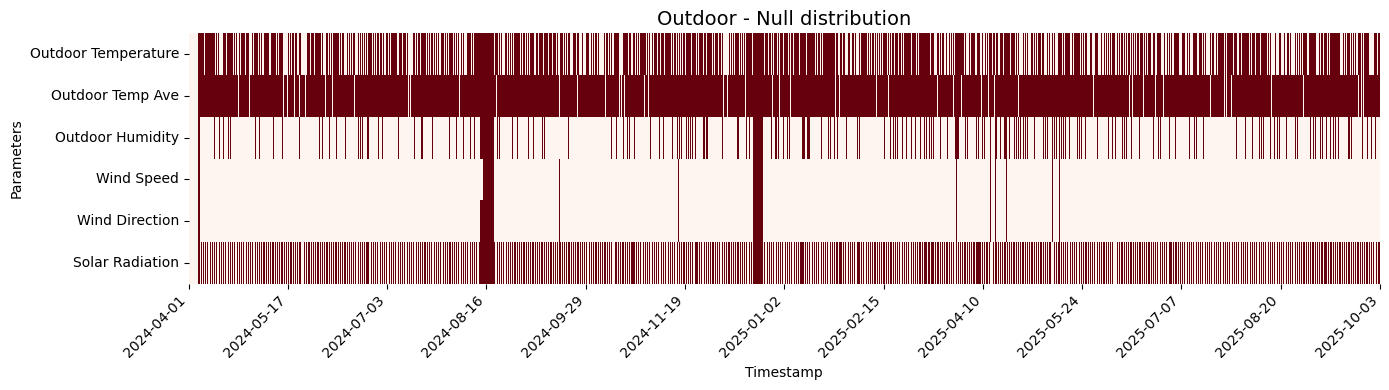

In [13]:
col_group_name = "Outdoor"
cols = outdoor_cols

# Create a boolean mask for missing values in the selected columns
null_mask = bms_df[cols].isna()

# Use the Timestamp column as the index for visualization
null_mask.index = bms_df["Timestamp"]

# Adjust figure height based on number of rows (columns to visualize)
n_rows = len(null_mask.columns)
fig_height = max(4, n_rows * 0.18)

# Create the heatmap
plt.figure(figsize=(14, fig_height))
ax = sns.heatmap(
    null_mask.T,          # Transpose so features are on Y-axis
    cmap="Reds",          # Color map (red = missing)
    cbar=False,           # Hide color bar
    yticklabels=null_mask.columns  # Show column names on Y-axis
)

# Set title and labels
ax.set_title(f"{col_group_name} - Null distribution", fontsize=14)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Parameters")

# ---- Format x-axis: show only date (no hours/minutes/seconds) ----
# Pick ~12 evenly spaced ticks to avoid overcrowding
n_ticks = 12
step = max(1, len(null_mask) // n_ticks)
positions = np.arange(0, len(null_mask), step)
labels = null_mask.index.strftime("%Y-%m-%d")[::step]

ax.set_xticks(positions + 0.5)  # +0.5 to align with heatmap cells
ax.set_xticklabels(labels, rotation=45, ha="right")

# Adjust layout for better fit
plt.tight_layout()
plt.show()


# 4.2 Correlation Analysis

In [27]:
bms_corr_fcu1 = (
    bms_df[['FCU-1 Cooling Load_kW', 'FCU-01 Supply Air Temp', 
            'FCU-01 Supply Air Humi', 'FCU-01 Supply Air Flow Rate', 
            'FCU-01 Return Temp', 'FCU-01 Return Air Humi', 
            'FCU-01 Return Air CO2 Level', 'FCU-01 CHW Supply Temp', 
            'FCU-01 CHW Return Temp', 'FCU-01 CHW Flow Rate']]
    .dropna()                                   # eliminate NaN 
    .loc[lambda df: (df != 0).all(axis=1)]    # eliminate rows with 0 values
)

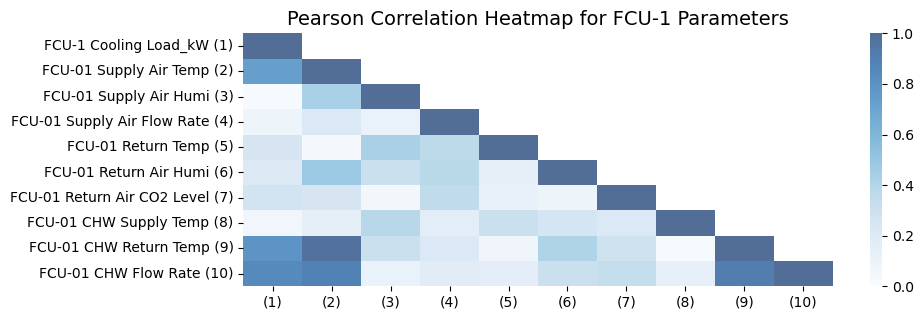

In [36]:
# 1. Pearson correlation
corr_matrix = bms_corr_fcu1.corr(method='pearson')

# 2. number + label
y_labels = [f"{col} ({i+1})" for i, col in enumerate(corr_matrix.columns)]
x_labels = [f"({i+1})" for i in range(len(corr_matrix.columns))]

# 3. Visualize Heatmap
plt.figure(figsize=(10,3.3))
sns.heatmap(corr_matrix.abs(), 
            cmap="Blues",
            # annot=True,
            # fmt=".2f",
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool), k=1),
            vmin=0, vmax=1,
            cbar=True,
            xticklabels=x_labels,   # X axis: (1), (2), (3)...
            yticklabels=y_labels,   # Y axis: (1) parameter name
            alpha=0.7)

plt.title("Pearson Correlation Heatmap for FCU-1 Parameters", fontsize=14)
plt.tight_layout()
plt.show()



# 4.3 Feature Distribution

### (1) Final Feature List

In [47]:
final_cols = {
    'Timestamp': ['Timestamp'],
    'FCU': ['FCU-1 Cooling Load_kW', 'FCU-2 Cooling Load_kW', 'FCU-3 Cooling Load_kW', 'FCU-4 Cooling Load_kW','FCU-5 Cooling Load_kW'],
    'PFCU': ['PFCU-1 Cooling Load_kW','PFCU-2 Cooling Load_kW'],
    'Outdoor': ['Outdoor Temperature', 'Outdoor Humidity', 'Wind Speed', 'Wind Direction', 'Solar Radiation'],
    'Indoor_temp': ['Zone 1 Temperature', 'Zone 2 Temperature','Zone 3 Temperature', 'Zone 4 Temperature', 'Zone 5 Temperature'],
    'Occupancy': ['Zone 1  CO2 - S1','Zone 2 CO2','Zone 3  CO2', 'Zone 4 CO2','Zone 5 CO2 - S1'],
    'Window': ['Z7 Windows Open Close Status', 'Z6 Windows Open Close Status',
               'Z5 Windows Open Close Status', 'Z1 Windows Open Close Status',
               'Z2 Windows Open Close Status', 'Z3 Windows Open Close Status'],
    'Fan': ['Zone 1 Fan-1 Control', 'Zone 1 Fan-2 Control', 'Zone 1 Fan-3 Control', 'Zone 1 Fan-4 Control', 'Zone 1 Fan-5 Control', 'Zone 1 Fan-6 Control', 'Zone 1 Fan-7 Control',
            'Zone 2G1 Fan-1 Control', 'Zone 2G1 Fan-2 Control', 'Zone 2G1 Fan-3 Control', 'Zone 2G1 Fan-4 Control', 'Zone 2G1 Fan-5 Control', 'Zone 2G1 Fan-6 Control', 
            'Zone 2G2 Fan-1 Control', 'Zone 2G2 Fan-2 Control', 'Zone 2G2 Fan-3 Control', 'Zone 2G2 Fan-4 Control', 'Zone 2G2 Fan-5 Control', 'Zone 2G2 Fan-6 Control',
            'Zone 3 Fan-1 Control', 'Zone 3 Fan-2 Control', 'Zone 3 Fan-3 Control', 'Zone 3 Fan-4 Control',
            'Zone 4 Fan-1 Control', 'Zone 4 Fan-2 Control', 'Zone 4 Fan-3 Control', 'Zone 4 Fan-4 Control', 'Zone 4 Fan-5 Control', 'Zone 4 Fan-6 Control',
            'Zone 5 Fan-1 Control', 'Zone 5 Fan-2 Control', 'Zone 5 Fan-3 Control', 'Zone 5 Fan-4 Control'
]
}

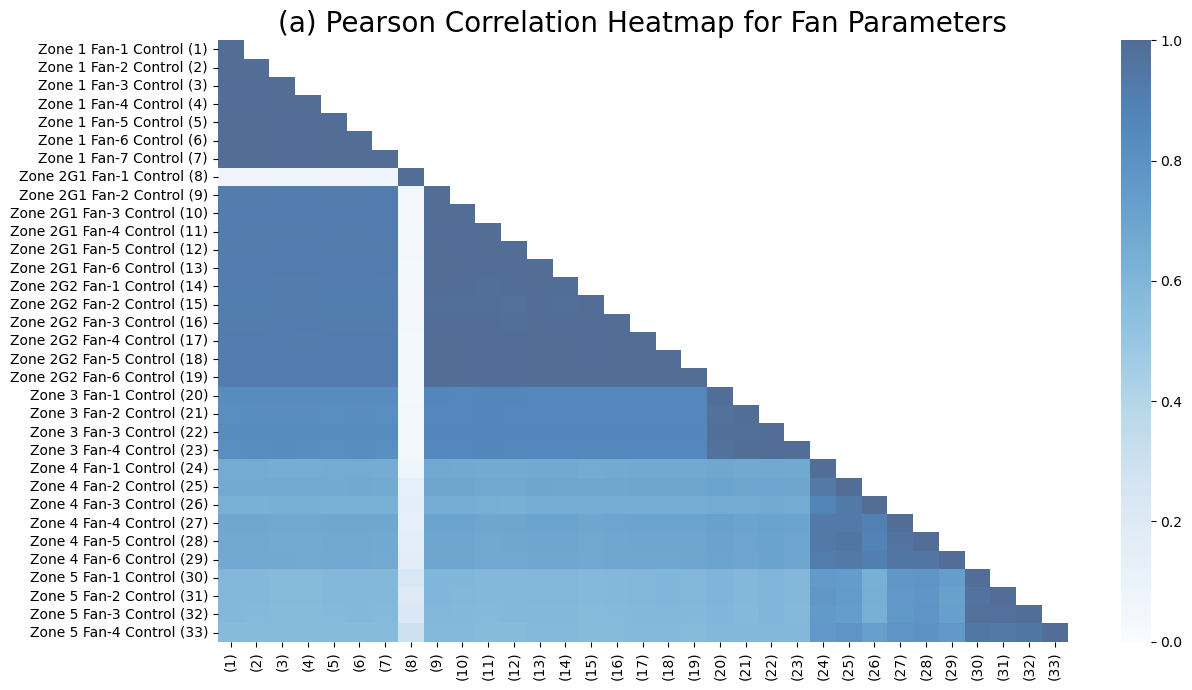

In [95]:
# 1. Pearson correlation
corr_matrix = bms_df[final_cols['Fan']].corr(method='pearson')

# 2. number + label
y_labels = [f"{col} ({i+1})" for i, col in enumerate(corr_matrix.columns)]
x_labels = [f"({i+1})" for i in range(len(corr_matrix.columns))]

# 3. Visualize Heatmap
plt.figure(figsize=(13,7))
sns.heatmap(corr_matrix.abs(), 
            cmap="Blues",
            # annot=True,
            # fmt=".2f",
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool), k=1),
            vmin=0, vmax=1,
            cbar=True,
            xticklabels=x_labels,   # X axis: (1), (2), (3)...
            yticklabels=y_labels,   # Y axis: (1) parameter name
            alpha=0.7)

plt.title("(a) Pearson Correlation Heatmap for Fan Parameters", fontsize=20)
plt.tight_layout()
plt.show()

<Figure size 1500x400 with 0 Axes>

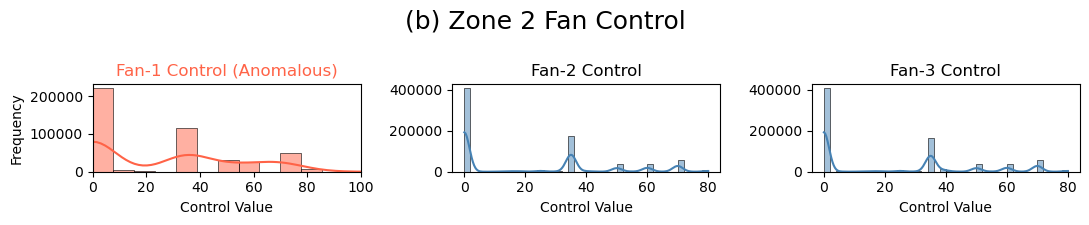

In [ ]:
plt.figure(figsize=(15,4))

# 3 subplot
fig, axes = plt.subplots(1, 3, figsize=(11,2.2))
# Fan-1
sns.histplot(bms_df['Zone 2G1 Fan-1 Control'], kde=True, bins=40, ax=axes[0], color='tomato')
axes[0].set_title("Fan-1 Control (Anomalous)", fontsize=12, color='tomato')
axes[0].set_xlabel("Control Value")
axes[0].set_xlim([0, 100])
axes[0].set_ylabel("Frequency")

# Fan-2
sns.histplot(bms_df['Zone 2G1 Fan-2 Control'], kde=True, bins=40, ax=axes[1], color='steelblue')
axes[1].set_title("Fan-2 Control", fontsize=12)
axes[1].set_xlabel("Control Value")
axes[1].set_ylabel("")

# Fan-3
sns.histplot(bms_df['Zone 2G1 Fan-3 Control'], kde=True, bins=40, ax=axes[2], color='steelblue')
axes[2].set_title("Fan-3 Control", fontsize=12)
axes[2].set_xlabel("Control Value")
axes[2].set_ylabel("")
plt.suptitle("(b) Zone 2 Fan Control", fontsize=18, y=1.0)
plt.tight_layout()
plt.show()


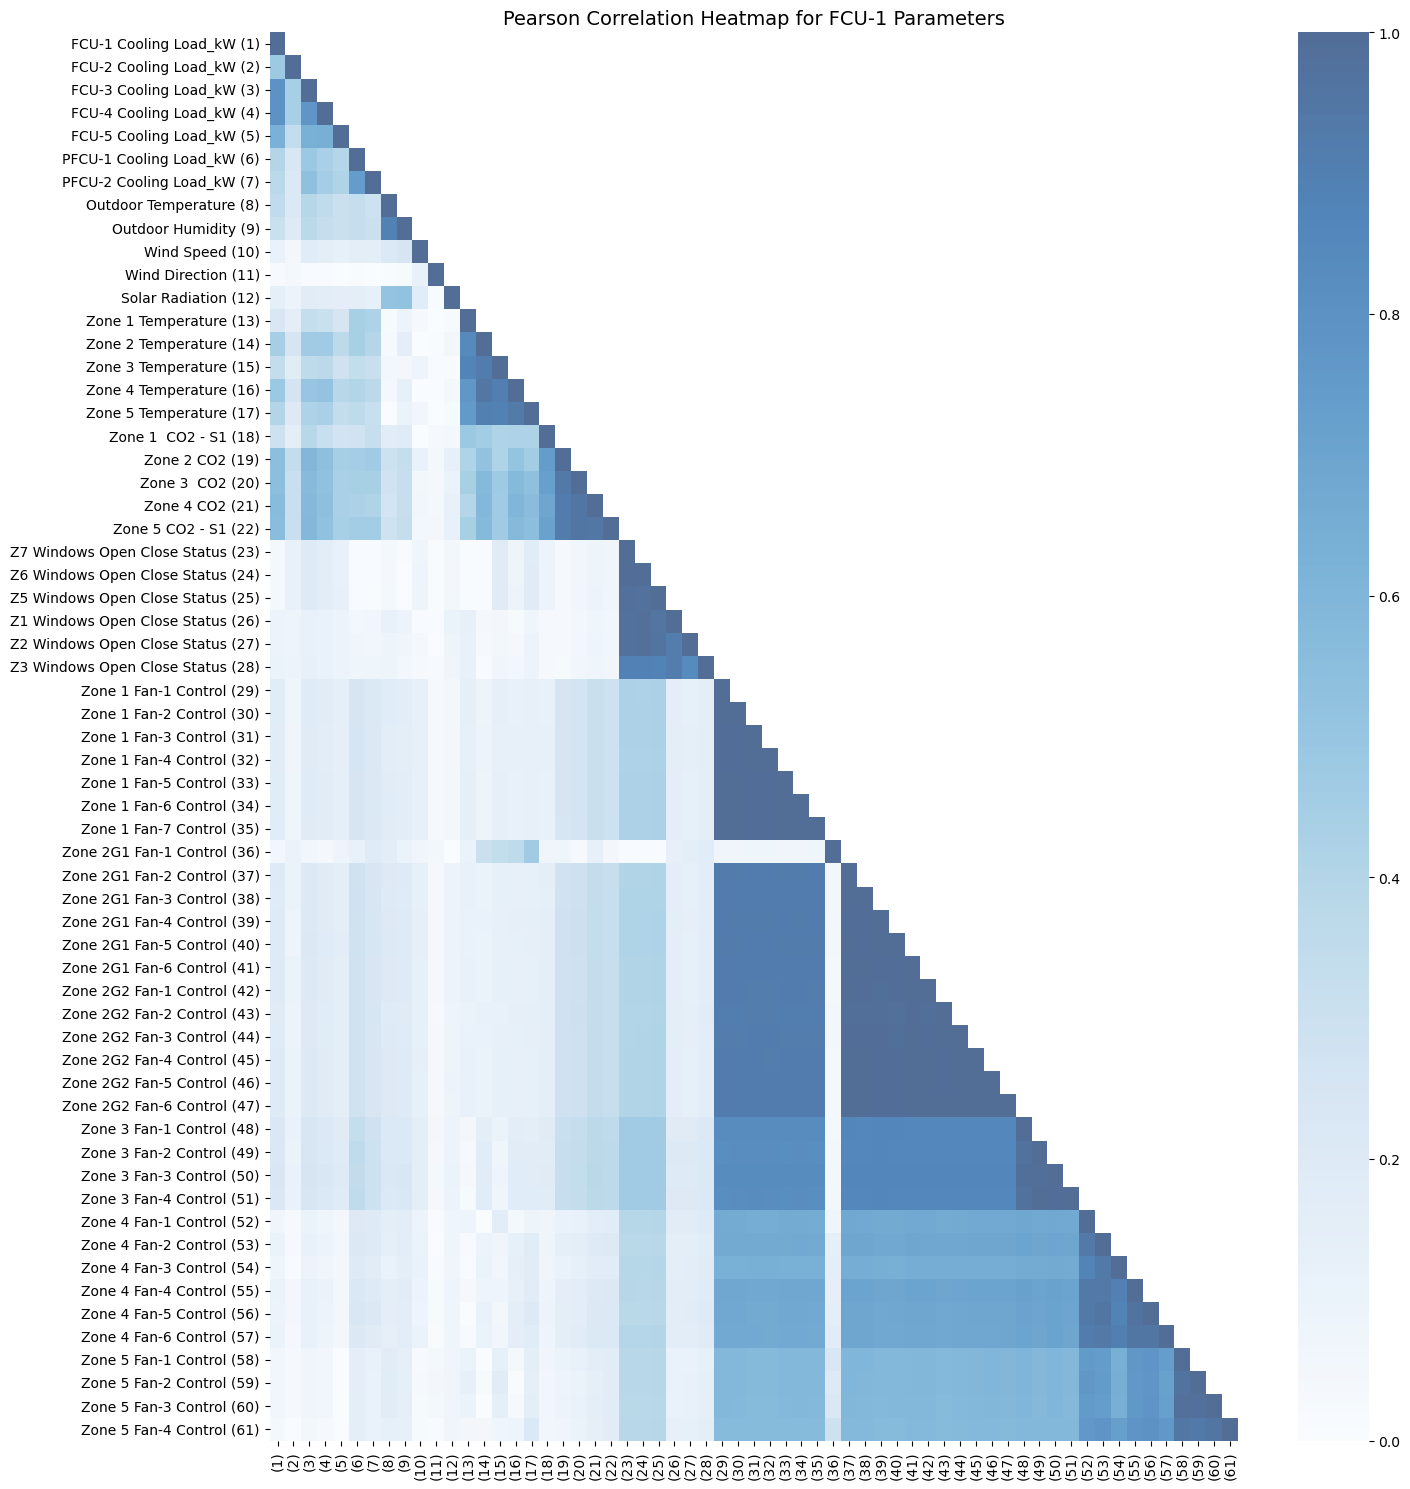

In [55]:
# 1. Pearson correlation
corr_matrix = bms_df[final_cols['FCU']+final_cols['PFCU']+final_cols['Outdoor']+final_cols['Indoor_temp']+final_cols['Occupancy']+final_cols['Window']+final_cols['Fan']].corr(method='pearson')

# 2. number + label
y_labels = [f"{col} ({i+1})" for i, col in enumerate(corr_matrix.columns)]
x_labels = [f"({i+1})" for i in range(len(corr_matrix.columns))]

# 3. Visualize Heatmap
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix.abs(), 
            cmap="Blues",
            # annot=True,
            # fmt=".2f",
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool), k=1),
            vmin=0, vmax=1,
            cbar=True,
            xticklabels=x_labels,   # X axis: (1), (2), (3)...
            yticklabels=y_labels,   # Y axis: (1) parameter name
            alpha=0.7)

plt.title("Pearson Correlation Heatmap for FCU-1 Parameters", fontsize=14)
plt.tight_layout()
plt.show()

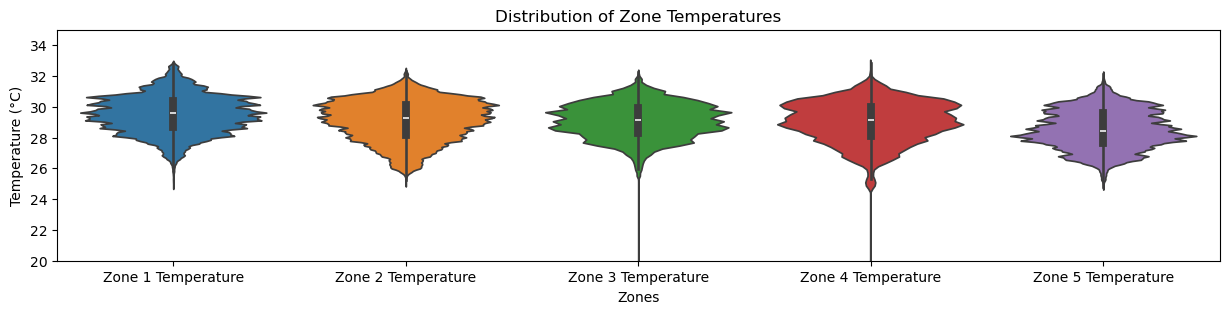

In [17]:
# Zone Temperature

plt.figure(figsize=(15,3))
sns.violinplot(data=bms_df[final_cols['Indoor_temp']])
plt.title("Distribution of Zone Temperatures")
plt.ylabel("Temperature (°C)")
plt.xlabel("Zones")
plt.ylim([20, 35])
plt.show()

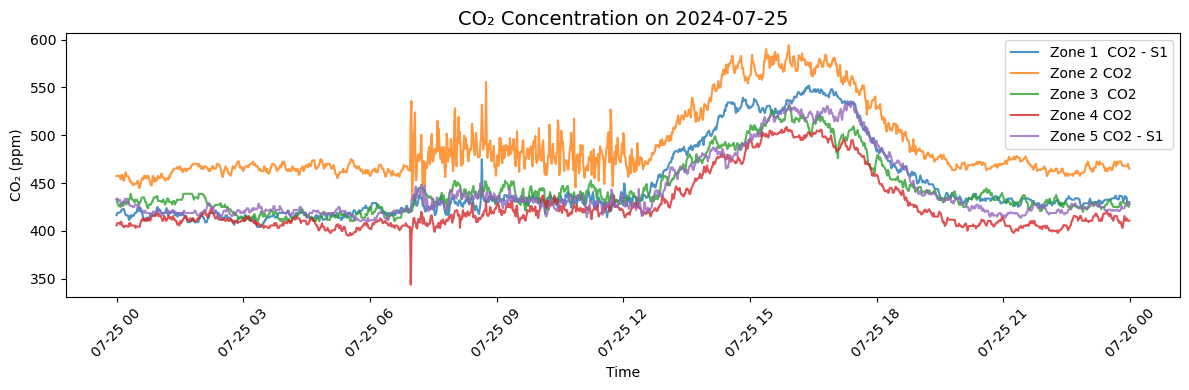

In [ ]:
# select the date
date = "2024-07-25"

# data filtering for a day
day_data = bms_df[bms_df["Timestamp"].dt.date == pd.to_datetime(date).date()]


# visualize
plt.figure(figsize=(12,4))
for col in final_cols['Occupancy']:
    plt.plot(day_data["Timestamp"], day_data[col], label=col, alpha=0.8)

plt.title(f"CO₂ Concentration on {date}", fontsize=14)
plt.xlabel("Time")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

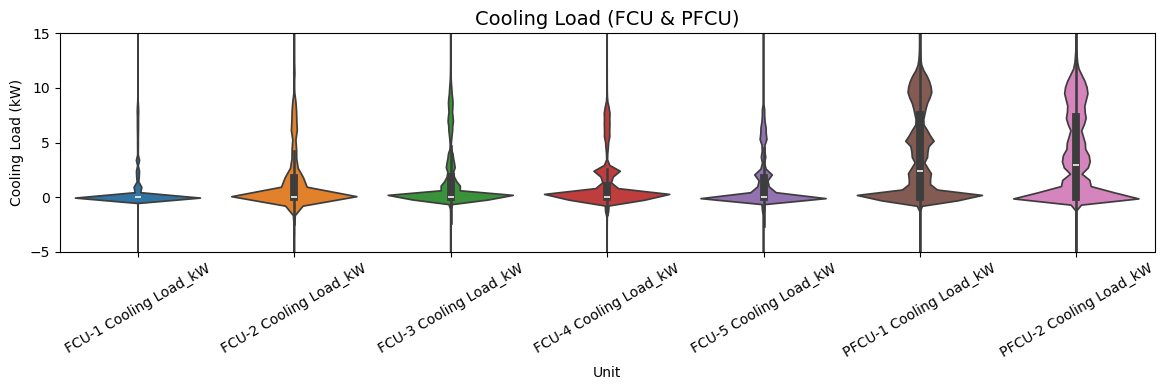

In [39]:
# Boxplot
plt.figure(figsize=(12,4))
sns.violinplot(data=bms_df[final_cols['FCU']+final_cols['PFCU']][:300000])

plt.title("Cooling Load (FCU & PFCU)", fontsize=14)
plt.ylabel("Cooling Load (kW)")
plt.xlabel("Unit")
plt.ylim([-5, 15])
plt.xticks(rotation=30)  
plt.tight_layout()
plt.show()

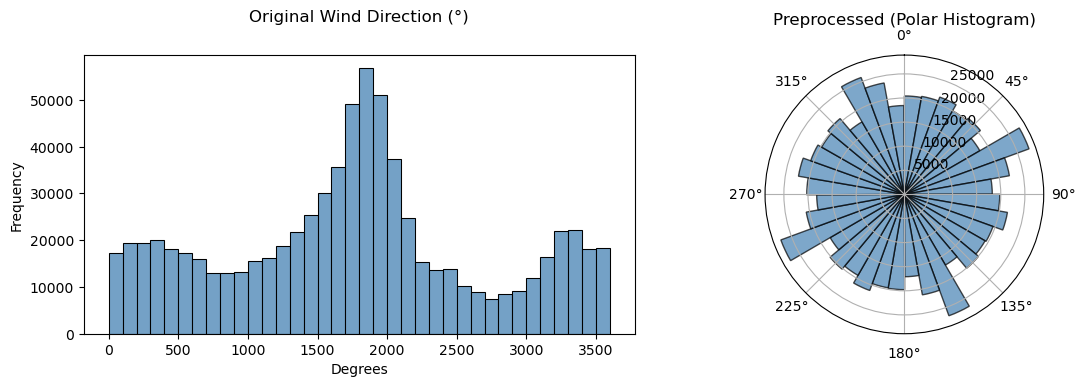

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, polar=True)

# (a) before processing
sns.histplot(bms_df["Wind Direction"], bins=36, kde=False, ax=ax1, color='steelblue')
ax1.set_title("Original Wind Direction (°)", y=1.09)   # 제목을 살짝 올림
ax1.set_xlabel("Degrees")
ax1.set_ylabel("Frequency")

# (b) after processing
angles = np.deg2rad(bms_df["Wind Direction"] % 360)
ax2.hist(angles, bins=36, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_title("Preprocessed (Polar Histogram)", y=1.08)  # ↓ 살짝 내림

plt.tight_layout()
plt.show()
